# Validatie gemeten waterpeilen Dwarsdiep  

Waterschap Noorderzijlvest met waterstanden op het Dwarsdiep benedenstrooms van de gemalen Wemerpolder en Oude Riet. Beide gemalen staan dicht bij elkaar en zouden vergelijkbare peien op het Dwarsdiep moeten laten zien. 

Het debietmeetpunt Hoge Tilweg ligt iets meer stroomafwaarts. Deze data worden ingeladen om ze samen met de data van de gemalen in één grafiek te kunnen zetten.

Dit notebook beschrijft de validatie van de meetgegevens van Wemerpolder en Oude Riet. Na validatie worden uit de kwartierwaarden dagwaarden berekend als basis voor een frequentieanalyse. 

Auteur: Thomas de Meij (Staatsbosbeheer)  
Datum : 18 juni 2021  


In [40]:
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
##import matplotlib.lines as mlines
##import matplotlib.transforms as mtransforms
from matplotlib import ticker as tick
import seaborn as sns
import scipy
from scipy import stats
sns.set_style("whitegrid")

datadir = r'..\02_data\validatie waterpeilen\\'
figdir = r'..\03_result\validatie waterpeilen\\'

## Inlezen van de meetgegevens  

### Wemerpolder en Oude Riet

In [41]:
fpath = r'..\01_source\data gemalen\210423_data gemalen dwarsdiep.xlsx'
data = pd.read_excel(fpath)

colnames = {'Datumtijd':'datumtijd',
    'Waterstand benedenstrooms Wemerpolder [m NAP]':'wmpnap',
    'Waterstand benedenstrooms Oude Riet [m NAP]':'odrnap'}
data = data.rename(columns=colnames)


De dataset bestaat uit 311954 kwartierwaarden vanaf 1 mei 2012 17:15 tot en met 25 maart 2021 13:00.  

### Debietmeetpunt Hoge Tilweg

In [42]:
# read data
fpath = r'..\01_source\data hoge tilweg\210608_debietmeetpunt_dwarsdiep.xlsx'
htw = pd.read_excel(fpath,sheet_name='Blad2')

# rename colnames
colnames = {'Datumtijd':'datumtijd',
    'Waterhoogte [m NAP]':'htwnap',
    'Debiet [m3/s]':'htwm3s'}
htw = htw.rename(columns=colnames)
htw = htw.set_index(keys='datumtijd',drop=True)

# sneak preview van de data
htw.head(7)

,htwnap,htwm3s
datumtijd,,
2014-08-01 10:30:00,-0.86,0.868
2014-08-01 10:45:00,-0.86,0.702
2014-08-01 11:00:00,-0.86,0.879
2014-08-01 11:30:00,-0.86,0.786
2014-08-01 11:45:00,-0.86,0.889
2014-08-01 12:15:00,-0.86,0.769
2014-08-01 12:30:00,-0.86,0.878


## Consistentie van de data  

Allereerst beoordelen we de consistentie van de data. Daarbij controleren we of alle kwartierwaareden in de meetperiode precies één keer voorkomen. Eerst controleren we de kolom datumtijd op dubbele waarden. Vervolgens controlen we of bij dubbele waarden voor datumtijd ook de gemeten waterpeilen gelijk zijn. Tenslotte verwijderen we de buplicaten.  

Voorafgaand aan de controle zetten we de beide meetreeksen in aparte variabelen, die we afonderlijk valideren:  

In [43]:
wmpnap = data[['datumtijd','wmpnap']]
odrnap = data[['datumtijd','odrnap']]


#### Beoordelen en verwijderen duplicaten Wemerpolder  

In [44]:
# aantal dubbele waarden voor datumtijd:
doubledates = wmpnap.duplicated(subset=['datumtijd'],keep=False)
print(f'Aantal dubbele waarden voor datumtijd in wemerpolder: {len(wmpnap[doubledates])}')

Aantal dubbele waarden voor datumtijd in wemerpolder: 52


In [45]:
# aantal dubbele waarden voor datumtijd én waterpeil in Wemerpolder:
duplicates = wmpnap.duplicated(subset=['datumtijd','wmpnap'],keep=False)
print(f'Aantal dubbele waarden voor datumtijd en waterpeil in wemerpolder: {len(wmpnap[duplicates])}')

Aantal dubbele waarden voor datumtijd en waterpeil in wemerpolder: 50


In [46]:
# wat zijn de dubbele waarden voor datumtijd en waterpeil?
wmpnap[doubledates&~duplicates]

,datumtijd,wmpnap
157667,2016-10-30 02:45:00,-0.93
157671,2016-10-30 02:45:00,-0.94


De meetreeks van Wemerpolder bevat 52 regels met dubbele waarden voor datumtijd (26 duplicaten). Van die 26 duplicaten hebben er 25 ook dezelfde waarde voor het waterpeil, op één duplicaatmeting na. Het verschil in waterpeil voor het duplicaat is 1 cm. Gezien deze resultaten wordt van alle 26 duplicaten van Wemperpolder alleen de eerstvoorkomende waarde bewaard:  

In [47]:
# drop duplicates datumtijd from Wemerpolder
wmpnap = wmpnap.drop_duplicates(subset=['datumtijd'],keep='first')

#### Beoordelen en verwijderen duplicaten Oude Riet  

In [48]:
# aantal dubbele waarden voor datumtijd:
doubledates = odrnap.duplicated(subset=['datumtijd'],keep=False)
print(f'Aantal dubbele waarden voor datumtijd in Oude Riet: {len(odrnap[doubledates])}')

Aantal dubbele waarden voor datumtijd in Oude Riet: 52


In [49]:
# aantal dubbele waarden voor datumtijd en waterpeil in Wemerpolder:
duplicates = odrnap.duplicated(subset=['datumtijd','odrnap'],keep=False)
print(f'Aantal dubbele waarden voor datumtijd en waterpeil in Oude Riet: {len(odrnap[duplicates])}')

Aantal dubbele waarden voor datumtijd en waterpeil in Oude Riet: 34


In [50]:
# hoe zien de duplicaten voor datumtijd en waterpeil eruit?
odrnap[doubledates&~duplicates].sort_values(by=['datumtijd','odrnap'])

,datumtijd,odrnap
17224,2012-10-28 02:30:00,-0.89
17221,2012-10-28 02:30:00,-0.88
87104,2014-10-26 02:00:00,-0.96
87108,2014-10-26 02:00:00,-0.95
122051,2015-10-25 02:45:00,-0.92
122055,2015-10-25 02:45:00,-0.91
157664,2016-10-30 02:00:00,-0.92
157668,2016-10-30 02:00:00,NaN
192608,2017-10-29 02:00:00,-0.91
192612,2017-10-29 02:00:00,NaN


De meetreeks van kwartierwaarden van Oude Riet bevat 52 regels met dubbele datumtijden. Daarvan hebben er 34 ook hetzelfde waterpeil. Voor de overige deplicaten is de meetwaarde NaN, of verschillen de beide meetwaarden slechts één centimeter. Gezien deze resultaten wordt van alle duplicaten alleen de eerstvoorkomende waarde bewaard:  

In [51]:
odrnap = odrnap.sort_values(by=['datumtijd','odrnap']).drop_duplicates(subset=['datumtijd'],keep='first').reset_index(drop=True)

## Aantal onbrekende waarden  

De volgende controle is het ontbreken van kwartierwaarden. Om dat te controleren wordt de dataset uitgelijnd op een nieuwe index van kwartierwaarden waarvan zeker is dat alle kwartieren tussen het begin en het eind van de meetperiode erin voorkomen. Kwartieren die ontbreken in de oorspronkelijke reeks krijgen daarbij de waarde NaN:  

In [52]:
# create index of 15 minute values
dtindex = pd.date_range(start='2012-05-01 17:15:00', end='2021-03-25 13:00:00', freq='15min')

# set datumtijd as index and realign to new index
wmpnap = wmpnap.set_index(keys='datumtijd',drop=True).reindex(dtindex)
odrnap = odrnap.set_index(keys='datumtijd',drop=True).reindex(dtindex)

In [53]:
# count missing values in orignal series of quarter hours
print(f'Aantal ontbrekende kwartierwaarden in Wmerpolder {wmpnap.isna().sum()}')

Aantal ontbrekende kwartierwaarden in Wmerpolder wmpnap    73
dtype: int64


In [54]:
# count missing values in calculated series of daily values
isna_wmp = wmpnap.groupby(pd.Grouper(freq='D')).mean().isna().sum()
print(f'Aantal ontbrekende dagwaarden in Wemerpolder {isna_wmp}')

Aantal ontbrekende dagwaarden in Wemerpolder wmpnap    0
dtype: int64


In [55]:
print(f'Aantal ontbrekende kwartierwaarden in Oude Riet {odrnap.isna().sum()}')

Aantal ontbrekende kwartierwaarden in Oude Riet odrnap    6218
dtype: int64


In [56]:
isna_odr = odrnap.groupby(pd.Grouper(freq='D')).mean().isna().sum()
print(f'Aantal ontbrekende dagwaarden in Oude Riet {isna_odr}')

Aantal ontbrekende dagwaarden in Oude Riet odrnap    40
dtype: int64


Samenvattend: in de meetreeks van Wemerpolder ontbreken 73 kwartierwaarnemingen van de waterstand. Er zijn geen dagen zonder gemeten kwartierwaarden. In de reeks van Oude Riet ontbreken 6218 kwartierwaarden. Er zijn 40 dagen zonder een gemeten kwartierwaarde, op een totaal van 3211 dagen.  

## Beschrijvende statistieken van de meetreeksen  

Onderstaande tabel geeft beschrijvende statistieken van beide meetreeksen. Om alle bewerkingen overzichtelijk te houden worden de twee afzonderlijke meetreeksen eerst weer samengevoegd in één dataframe:  

In [57]:
data = pd.merge(wmpnap,odrnap,left_index=True,right_index=True,how='outer')
data.index.name = "datumtijd"
fpath = f'{datadir}kwartierwaarden wemerpolder en oude riet.csv' 
data.to_csv(fpath)

In [58]:
data

,wmpnap,odrnap
datumtijd,,
2012-05-01 17:15:00,-0.82,-0.85
2012-05-01 17:30:00,-0.83,-0.86
2012-05-01 17:45:00,-0.82,-0.85
2012-05-01 18:00:00,-0.82,-0.85
2012-05-01 18:15:00,-0.83,-0.86
...,...,...
2021-03-25 12:00:00,-0.84,NaN
2021-03-25 12:15:00,-0.84,-0.82
2021-03-25 12:30:00,-0.84,-0.82


In [59]:
dstat = data.describe()
fpath = f'{datadir}statistieken kwartierwaarden wemerpolder en oude riet.xlsx'
dstat.to_excel(fpath)
dstat

,wmpnap,odrnap
count,311911.000000,305766.000000
mean,-0.873477,-0.888739
std,0.056215,0.137871
min,-1.130000,-1.940000
25%,-0.910000,-0.910000
50%,-0.880000,-0.880000
75%,-0.850000,-0.850000
max,-0.390000,0.000000


In [60]:
# beschrijvende statistieken Hoge Tilweg
htw.describe()

,htwnap,htwm3s
count,87727.000000,87727.000000
mean,-0.862693,1.103697
std,0.052662,1.139094
min,-1.100000,-1.370000
25%,-0.900000,0.441000
50%,-0.870000,0.761000
75%,-0.840000,1.369000
max,-0.470000,14.814000


Bovenstaande tabel leidt tot de volgende conclusies:
- De mediaan van beide reeksen van kwartierwaarden is -0,88 mNAP. Dat betekent dat de waterstand de helft van de tijd lager is dan -0,88 m NAP en de andere helft van de tijd hoger.  
- De gemeten waterpeilen liggen tussen -1,13 m NAP en -0,39 mNAP voor gemaal Wemerpolder en tussen -1,94 mNAP en 0 mNAP voor gemaal Oude Riet. Het voorkomen van maximum waarden van 0 mNAP in de meetreeks van Oude Riet is op grond van de voorkomende waterpeilen zeer onwarschijnlijk. Zijn dit wellicht missing values die als 0 zijn gecodeerd?  

## Grafieken van de metingen

Om een eerste indruk te krijgen van de metingen worden de ruwe data geplot (Let op: de schaalverdeling op de y-assen van beide grafieken is niet gelijk):

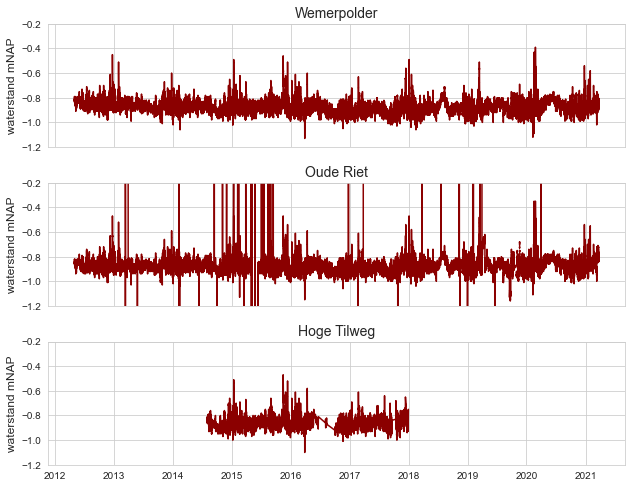

In [61]:
def plot_rawdata(data):
    """Plot timegraph of raw measurements"""
    fig,axs = plt.subplots(nrows=3, ncols=1,sharex=True,sharey=True)
    fig.set_size_inches(9,7) # w,h

    x = data.index.values
    y = data['wmpnap'].values
    axs[0].plot(x,y,color='#8b0000')
    axs[0].set_title('Wemerpolder',fontsize=14.)
    
    y = data['odrnap'].values
    axs[1].plot(x,y,color='#8b0000')
    axs[1].set_title(label='Oude Riet',fontsize=14.)
    
    x = htw.index.values
    y = htw['htwnap'].values
    axs[2].plot(x,y,color='#8b0000')
    axs[2].set_title(label='Hoge Tilweg',fontsize=14.)
    
    for ax in axs:
        ax.set_ylabel('waterstand mNAP',fontsize=12.)
    
    fig.tight_layout(pad=1.5)
    axs[0].set_ylim(-1.2,-0.2)

    return fig,axs

fig,ax = plot_rawdata(data)
fpath = f'{figdir}tijdreeksen kwartierwaarden Wemerpolde en Oude Riet.jpg'
fig.savefig(fpath,dpi=300,bbox_inches='tight')

## Betrouwbaarheid metingen Oude Riet

Het Dwarsdiep is onderdeel van de Electraboezem, het stelsel van waterlopen dat vrij afwatert richting Lauwersoog. Het streefpeil van de Electraboezem is -0,93 m NAP. Ver uitzakkende peilen zijn niet te verwachten, tijdelijk oplopende peilen in de winter wel. 

De grafieken geven de indruk dat de metingen van gemaal Wemerpolder op het oog betrouwbaar zijn, op incidentele uitschieters naar beneden na.  

De peilen van Oude Riet bevatten forse uitschieters, zowel naar boven als naar beneden. We onderzoeken wat voor soort waarnemingen dit zijn door de extreem hoge waarden (hoger dan -0,1 mNAP) en extreem lage waarden (lager dan -1,10 mNAP) te bekijken:

In [62]:
mask_upper = data['odrnap']>-0.3
print(f'Het aantal gemeten waterstanden hoger dan -0,3 mNAP is {len(data[mask_upper])}')

Het aantal gemeten waterstanden hoger dan -0,3 mNAP is 57


In [63]:
# sneak preview van waterstanden hoger dan -0,3 mNAP:
data[mask_upper].head(9)

,wmpnap,odrnap
datumtijd,,
2013-03-14 02:15:00,NaN,0.0
2013-03-14 02:30:00,NaN,0.0
2013-03-14 02:45:00,NaN,0.0
2013-03-14 03:00:00,NaN,0.0
2013-03-14 03:15:00,NaN,0.0
2013-03-14 03:30:00,NaN,0.0
2013-03-14 03:45:00,NaN,0.0
2013-03-14 04:00:00,NaN,0.0
2013-03-14 04:15:00,NaN,0.0


In [64]:
mask_lower = data['odrnap']<-1.20
print(f'Het aantal gemeten waterstanden lager dan -1,20 mNAP is {len(data[mask_lower])}')

Het aantal gemeten waterstanden lager dan -1,20 mNAP is 4274


In [65]:
# sneak preview lage waterstanden:
data[mask_lower].head(9)

,wmpnap,odrnap
datumtijd,,
2013-03-14 00:45:00,NaN,-1.94
2013-03-14 01:00:00,NaN,-1.94
2013-03-14 01:15:00,NaN,-1.94
2013-03-14 01:30:00,NaN,-1.94
2013-03-14 01:45:00,NaN,-1.94
2013-03-14 02:00:00,NaN,-1.94
2013-05-27 10:00:00,-0.90,-1.45
2014-02-09 20:15:00,-0.91,-1.94
2014-02-09 20:30:00,-0.92,-1.94


De bepertke beoordeling van hoge en lage meetwaarden van gemaal Oude Riet doet vermoeden dat de 0-waarden feitelijk fout gecodeerde missing values zijn. Het gaat om 57 kwartierwaarden verspreid over de dataset. 

De meetwaarden lager dan -1,20 m NAP zijn mogelijk wel echte "gemeten" waarden, maar deze waterpeilen komen in werkelijkheid niet voor. Er lijkt sprake van meetfouten die worden veroorzaakt door de meetopstelling. Zonder kennis van het meetpunt en de wijze waarop fouten kunnen ontstaan is niet duidelijk hoe verantwoord correcties kunnen worden uitgevoerd.  De gemeten peilen van Oude Riet worden daarom verder niet gebruikt.

Ter illustratie van de effecten van eventuele aanpassing van de reeks wordt hieronder een grafiek getoond van de metingen van beide gemalen, waarbij waarden kleiner dan -1,20 m NAP en groter dan -0,30 m NAP van Oude Riet zijn vervangen door missing values:  

In [66]:
# vervangen van hoge en lage waarden van Oude Riet door missing values
datacor = data.copy()
datacor['odrnap'] = datacor['odrnap'].where(~mask_upper,other=np.nan)
datacor['odrnap'] = datacor['odrnap'].where(~mask_lower,other=np.nan)

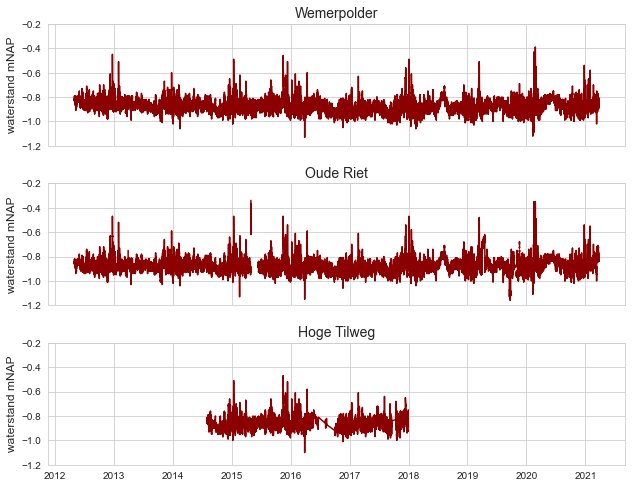

In [67]:
fig,ax = plot_rawdata(datacor)
fpath = f'{figdir}tijdreeks gecorrigeerde kwartierwaarden.jpg'
fig.savefig(fpath,dpi=300,bbox_inches='tight')

In [68]:
# alleen de metingen van Wemerpolder worden bewaard in een dataset met gevalideerde waarnemingen:
fpath = f'{datadir}wemerpolder_kwartierwaarden_gevalideerd.csv'
data['wmpnap'].to_csv(fpath)

## Dagwaarden Wemerpolder  
 
De metingen van het waterpeil op het Dwarsdiep geven inzicht in de kans op inundaties wanneer de kades langs het Dwarsdiep worden verwijderd. Het is daarvoor niet nodig om kwartierwaarden te gebruiken. Omdat de inundaties worden uitgedrukt in dagen, berekenen we dagwaarden van de waterstand uit de reeks van kwartierwaarden van Wemerpolder.   

Hoe kunnen de gemeten kwartierwaarden het beste worden vertaald naar een geschatte dagwaarde? Onderstaande tabel toont het gemiddelde, de mediaan, het minimum en het maximum van de 96 kwartierwaarden op een dag voor alle beschikbare dagen (alleen de eerste 5 rijen worden getoond):

In [69]:
daystats = data['wmpnap'].groupby(pd.Grouper(freq='D')).agg(['mean', 'median', 'min', 'max'])
daystats['range'] = daystats['max']-daystats['min']
daystats.head(5)

,mean,median,min,max,range
datumtijd,,,,,
2012-05-01,-0.822963,-0.82,-0.83,-0.81,0.02
2012-05-02,-0.810104,-0.81,-0.83,-0.79,0.04
2012-05-03,-0.821458,-0.82,-0.84,-0.81,0.03
2012-05-04,-0.824271,-0.83,-0.84,-0.80,0.04
2012-05-05,-0.812187,-0.81,-0.83,-0.79,0.04


De variatie van kwartierwaarden op een dag voor de hele dataset owrdt samengevat in onderstaande grafiek:

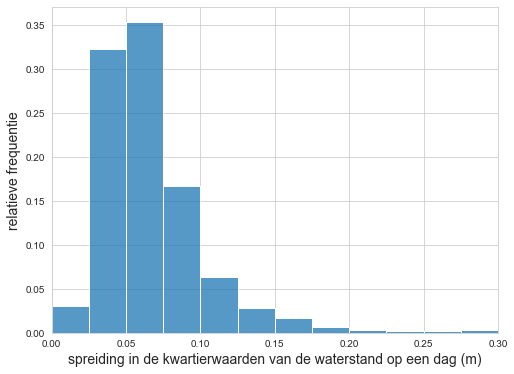

In [70]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(8,6) # w,h

sns.histplot(data=daystats, x="range", binwidth=0.025, stat='probability', ax=ax)
ax.set_xlabel('spreiding in de kwartierwaarden van de waterstand op een dag (m)',fontsize=14)
ax.set_ylabel('relatieve frequentie', fontsize=14)
ax.set_xlim(0,0.3)

fig.savefig(f'{figdir}wemerpolder - bereik kwartierwaarden binnen een dag.jpg',dpi=300)

Bovenstaande frequentieverdeling toont de maximale waterstandsverschillen binnen een dag. Daaruit blijkt dat maximale waterstandsverschillen tot 20 cm op een dag voorkomen, maar dat 85% van de variatie op een dag beperkt blijft tot 10 cm.  

Een redelijke schatting voor de "gemiddelde" dagwaarde van de waterstand zou de mediaan van de 96 kwartierwaarden op een dag kunnen zijn.  Maar omdat we voor de ecologische beoordeling van het effect van inundaties ook rekening willen kunnen houden met kortdurende zomerinundaties, schatten we de dagwaarde voor de waterstand als het 85e percentiel van de 96 kwartierwaarden op een dag. De dagwaarde is daarmee de waterstand die minumaal vier uur op een dag wordt overschreden.  

In [71]:
# 85e percentiel geeft de waterstand die 4 uur op een dag wordt overschreden:
1-(4*4)/(24*4)

0.8333333333333334

In [72]:
def q85(x):
    return x.quantile(0.85)
daystats['q85'] = data['wmpnap'].groupby(pd.Grouper(freq='D')).agg([q85])
daystats[:5]

,mean,median,min,max,range,q85
datumtijd,,,,,,
2012-05-01,-0.822963,-0.82,-0.83,-0.81,0.02,-0.82
2012-05-02,-0.810104,-0.81,-0.83,-0.79,0.04,-0.80
2012-05-03,-0.821458,-0.82,-0.84,-0.81,0.03,-0.82
2012-05-04,-0.824271,-0.83,-0.84,-0.80,0.04,-0.82
2012-05-05,-0.812187,-0.81,-0.83,-0.79,0.04,-0.80


In [73]:
daystats.describe()

,mean,median,min,max,range,q85
count,3251.000000,3251.000000,3251.000000,3251.000000,3251.000000,3251.000000
mean,-0.873458,-0.873731,-0.905927,-0.839080,0.066847,-0.852694
std,0.051487,0.053068,0.048566,0.059279,0.039320,0.057978
min,-1.017083,-1.050000,-1.130000,-0.980000,0.000000,-1.000000
25%,-0.904635,-0.910000,-0.940000,-0.870000,0.040000,-0.890000
50%,-0.877083,-0.880000,-0.910000,-0.850000,0.060000,-0.860000
75%,-0.847969,-0.850000,-0.880000,-0.810000,0.080000,-0.830000
max,-0.436979,-0.430000,-0.510000,-0.390000,0.630000,-0.400000


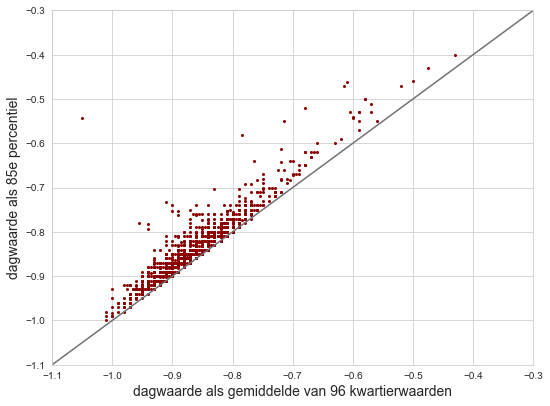

In [74]:
def scatterplot(daystats):
    """Plot water level versus discharge"""
    fig, ax = plt.subplots(nrows=1, ncols=1)
    fig.set_size_inches(8,6) # w,h

    x = daystats['median'].values
    y = daystats['q85'].values

    ax.scatter(x,y,color='#8b0000',s=4)
    ax.set_xlabel('dagwaarde als gemiddelde van 96 kwartierwaarden',fontsize=14)
    ax.set_ylabel('dagwaarde als 85e percentiel',fontsize=14)

    min = -1.1
    max = -0.3
    ax.plot([min,max], [min,max], color = '#726f77')
    ax.set_xlim(min,max)
    ax.set_ylim(min,max)

    fig.tight_layout(pad=2.0)

    return fig,ax

fig,ax = scatterplot(daystats)
fpath = f'{figdir}wemerpolder - verband tussen dagwaarde mediaan en 85e percentiel.jpg'
fig.savefig(fpath,dpi=300,bbox_inches='tight')

In [75]:
# save daily values for further processeing
wmp_q85 = data['wmpnap'].groupby(pd.Grouper(freq='D')).quantile(0.85)
fpath = f'{datadir}wemerpolder_dagwaarden_q85.csv'
wmp_q85.to_csv(fpath)

wmp_q50 = data['wmpnap'].groupby(pd.Grouper(freq='D')).median()
fpath = f'{datadir}wemerpolder_dagwaarden_mediaan.csv'
wmp_q50.to_csv(fpath)

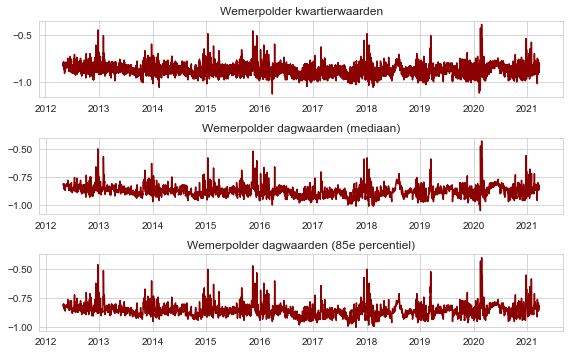

In [76]:
fig, ax = plt.subplots(nrows=3, ncols=1)
fig.set_size_inches(8,5) # w,h

x = data.index.values
y = data['wmpnap'].values
ax[0].plot(x,y,color='#8b0000')
ax[0].set_title('Wemerpolder kwartierwaarden')

x = wmp_q50.index.values
y = wmp_q50.values
ax[1].plot(x,y,color='#8b0000')
ax[1].set_title(label='Wemerpolder dagwaarden (mediaan)')

x = wmp_q85.index.values
y = wmp_q85.values
ax[2].plot(x,y,color='#8b0000')
ax[2].set_title(label='Wemerpolder dagwaarden (85e percentiel)')

fig.tight_layout(pad=1.0)

fpath = f'{figdir}Wemerpolder dagwaarden.jpg'
fig.savefig(fpath,dpi=300,bbox_inches='tight')


## Empirische frequentie gemeten waterpeilen  

De grafiek hieronder toont de empirische frequentieverdeling van de gemeten waterpeilen. Links voor de kwartierwaarden, midden voor de dagwaarden op basis van de mediaan en rechts de dagwaarden op basis van het 85e percentiel. De curve toont de theoretische normale verdeling voor het gemiddelde en standaarddeviatie van de metingen die zijn gebruikt voor het betreffende histogram.

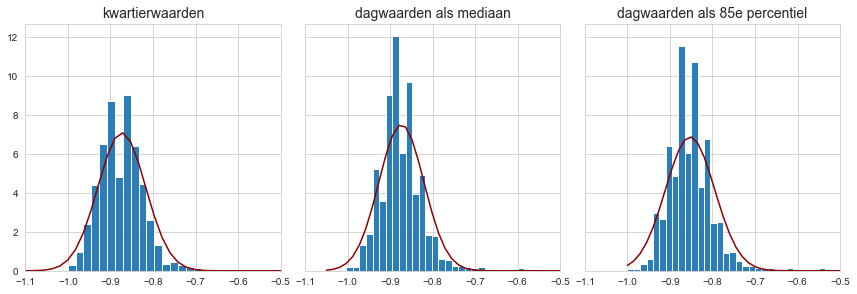

In [77]:

fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True)
fig.set_size_inches(12,4) # w,h
fig.tight_layout()

nbins = 40

cases = [
    {'data':data['wmpnap'],'axnr':0,'xlab':'kwartierwaarden'},
    {'data':wmp_q50,'axnr':1,'xlab':'dagwaarden als mediaan'},
    {'data':wmp_q85,'axnr':2,'xlab':'dagwaarden als 85e percentiel'},
    ]

for dict in cases:
    
    values = dict['data'].dropna()
    axnr = dict['axnr']
    m, bins, patches = ax[axnr].hist(values, nbins, density=1, alpha=0.95)

    mu, sigma = scipy.stats.norm.fit(values)
    best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
    ax[axnr].plot(bins, best_fit_line, color='#8b0000')
    
    ax[axnr].set_title(dict['xlab'],fontsize=14.)
    ax[axnr].set_xlim(-1.1,-0.5)

fpath = f'{figdir}wemerpolder frequentieverdeling waterstanden.jpg'
fig.savefig(fpath,dpi=300,bbox_inches='tight')